In [3]:
def macd(price_series, short_window=5, long_window=34, signal_window=5):
    # 1. Calculate EMAs
    short_ema = price_series.ewm(span=short_window, adjust=False).mean()
    long_ema = price_series.ewm(span=long_window, adjust=False).mean()

    # 2. MACD Line
    macd_line = short_ema - long_ema

    # 3. Signal Line (EMA of MACD)
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()

    # 4. Histogram (MACD - Signal)
    macd_hist = macd_line - signal_line

    # Return as a DataFrame
    return pd.DataFrame({
        "MACD": macd_line,
        "Signal Line": signal_line,
        "Histogram": macd_hist
    })

In [4]:
def weighted_moving_average(series, period):
    weights = np.arange(1, period + 1)
    return series.rolling(period).apply(lambda prices: np.dot(prices, weights)/weights.sum(), raw=True)

def hull_moving_average(series, period):
    half_length = int(period / 2)
    sqrt_length = int(np.sqrt(period))

    wma_half = weighted_moving_average(series, half_length)
    wma_full = weighted_moving_average(series, period)

    hull_series = 2 * wma_half - wma_full
    hma = weighted_moving_average(hull_series, sqrt_length)

    return hma

In [5]:
def process_stock_data(csv_url):
    # Load and prepare data
    df = pd.read_csv(csv_url)
    df['Open time'] = pd.to_datetime(df['Open time'])  # Ensure datetime format
    df.set_index('Open time', inplace=True)

    df['Year'] = df.index.year         # Extracts year as integer (e.g. 2020)
    df['Month'] = df.index.month       # Extracts month as integer (1–12)
    df['Weekday'] = df.index.weekday   # Monday = 0, Sunday = 6
    df['Hour'] = df.index.hour
    df['Minute'] = df.index.minute

    df['15minReturn'] = df['Close'] / df['Close'].shift(1) - 1
    df['15minrange'] = df['High'] - df['Low']
    df['Volchange'] = df['Volume'] / (df['Volume'].shift(1) + 1e-8) - 1

    # Calculate MACD and join to original DataFrame
    macd_r = macd(df["15minReturn"]).add_prefix("Ret_")
    df = df.join(macd_r)
    
    macd_v = macd(df["Volchange"]).add_prefix("Vol_")
    df = df.join(macd_v)

    df['HMA_20_Volume'] = hull_moving_average(df['Volume'], 20)
    df['HMA_50_Volume'] = hull_moving_average(df['Volume'], 50)
    df['HMA_100_Volume'] = hull_moving_average(df['Volume'], 100)
    df['HMA_200_Volume'] = hull_moving_average(df['Volume'], 200)

    # 5-day rolling volatility (daily returns)
    df['Volatility_5'] = df['15minReturn'].rolling(window=5).std()

    # 10-day rolling volatility
    df['Volatility_10'] = df['15minReturn'].rolling(window=10).std()

    # 20-day rolling volatility
    df['Volatility_20'] = df['15minReturn'].rolling(window=20).std()

    # Volume Z-score over past 20 days
    df['Volume_Z'] = (df['Volume'] - df['Volume'].rolling(20).mean()) / df['Volume'].rolling(20).std()

    # Price Z-score (on Close) over past 20 days
    df['Price_Z'] = (df['Close'] - df['Close'].rolling(20).mean()) / df['Close'].rolling(20).std()

    # Return Z-score over past 20 days
    df['Return_Z'] = (df['15minReturn'] - df['15minReturn'].rolling(20).mean()) / df['15minReturn'].rolling(20).std()

    ma_20 = df['Close'].rolling(20).mean()
    ma_std_20 = df['Close'].rolling(20).std()
    df['Z_Close_MA_20'] = (df['Close'] - ma_20) / ma_std_20

    df.dropna(inplace=True)
    
    return df

In [6]:
import numpy as np

def generate_volatility_labels(df, lookahead=12, n_classes=3):
    df = df.copy()

    # Compute log returns
    df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))

    # Calculate rolling future volatility (std of log returns)
    df['future_vol'] = (
        df['log_return']
        .shift(-lookahead + 1)  # Shift so we're looking forward
        .rolling(window=lookahead)
        .std()
    )

    # Drop rows with NaNs due to rolling and shifting
    df = df.iloc[:-lookahead]

    # Quantile binning to create classes
    df['volatility_class'] = pd.qcut(
        df['future_vol'],
        q=n_classes,
        labels=range(n_classes)
    )

    return df


In [7]:
df = process_stock_data("/Users/rong/Desktop/btc_15m_data_2018_to_2025.csv")
df = generate_volatility_labels(df, lookahead=12, n_classes=3)

In [8]:
df.dropna()

,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,...,Volatility_5,Volatility_10,Volatility_20,Volume_Z,Price_Z,Return_Z,Z_Close_MA_20,log_return,future_vol,volatility_class
Open time,,,,,,,,,,,,,,,,,,,,,
2018-01-03 07:45:00,15158.57,15231.51,15135.90,15170.00,172.989883,2018-01-03 07:59:59.999,2.626280e+06,1515,89.399478,1.357937e+06,...,0.005798,0.006533,0.006506,-0.815326,0.940688,0.015806,0.940688,0.000659,0.009372,2
2018-01-03 08:00:00,15170.00,15172.99,14910.00,14975.00,257.622957,2018-01-03 08:14:59.999,3.875107e+06,2153,160.337093,2.412682e+06,...,0.006159,0.007777,0.006694,0.880580,-0.572263,-1.826825,-0.572263,-0.012938,0.009560,2
2018-01-03 08:15:00,14974.98,15050.00,14900.00,14950.00,241.666106,2018-01-03 08:29:59.999,3.621941e+06,1927,143.733039,2.154657e+06,...,0.005375,0.007772,0.006619,0.603070,-0.712309,-0.183102,-0.712309,-0.001671,0.009695,2
2018-01-03 08:30:00,14968.02,15113.49,14950.00,15086.00,201.905635,2018-01-03 08:44:59.999,3.039620e+06,2006,129.801492,1.954690e+06,...,0.007837,0.008272,0.006802,-0.167519,0.363250,1.292182,0.363250,0.009056,0.009696,2
2018-01-03 08:45:00,15086.00,15113.49,15000.00,15002.59,194.740060,2018-01-03 08:59:59.999,2.934303e+06,1963,119.701303,1.804361e+06,...,0.008071,0.008311,0.006312,-0.247504,-0.432173,-0.976801,-0.432173,-0.005544,0.010265,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-16 20:00:00,108652.01,108693.21,108428.00,108646.31,241.133820,2025-06-16 20:14:59.999,2.617901e+07,38180,130.196620,1.413418e+07,...,0.002079,0.001560,0.001349,0.935354,1.506242,-0.398364,1.506242,-0.000052,0.003530,2
2025-06-16 20:15:00,108646.30,108648.68,108509.66,108626.77,93.391940,2025-06-16 20:29:59.999,1.013982e+07,19332,39.826400,4.323606e+06,...,0.001511,0.001515,0.001309,-0.924183,1.316000,-0.541088,1.316000,-0.000180,0.003586,2
2025-06-16 20:30:00,108626.77,108757.32,108559.89,108737.31,87.088030,2025-06-16 20:44:59.999,9.461555e+06,14678,53.431900,5.805273e+06,...,0.001429,0.001473,0.001314,-0.970460,1.408247,0.356865,1.408247,0.001017,0.003632,2


In [9]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Close time',
       'Quote asset volume', 'Number of trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume', 'Ignore', 'Year', 'Month', 'Weekday',
       'Hour', 'Minute', '15minReturn', '15minrange', 'Volchange', 'Ret_MACD',
       'Ret_Signal Line', 'Ret_Histogram', 'Vol_MACD', 'Vol_Signal Line',
       'Vol_Histogram', 'HMA_20_Volume', 'HMA_50_Volume', 'HMA_100_Volume',
       'HMA_200_Volume', 'Volatility_5', 'Volatility_10', 'Volatility_20',
       'Volume_Z', 'Price_Z', 'Return_Z', 'Z_Close_MA_20', 'log_return',
       'future_vol', 'volatility_class'],
      dtype='object')

In [13]:
df1 = df.iloc[:230000].copy()

In [14]:
df1.reset_index(drop=False)

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,...,Volatility_5,Volatility_10,Volatility_20,Volume_Z,Price_Z,Return_Z,Z_Close_MA_20,log_return,future_vol,volatility_class
0,2018-01-03 05:00:00,15031.01,15094.00,14900.00,15038.62,240.017596,2018-01-03 05:14:59.999,3.599147e+06,1587,149.584611,...,0.003463,0.006822,0.006111,0.562947,0.997622,0.045036,0.997622,NaN,NaN,NaN
1,2018-01-03 05:15:00,15033.87,15095.00,14990.00,15063.00,227.757728,2018-01-03 05:29:59.999,3.426303e+06,1273,130.665153,...,0.003430,0.006828,0.006008,0.291319,1.067851,0.140565,1.067851,0.001620,NaN,NaN
2,2018-01-03 05:30:00,15063.00,15114.98,15016.05,15016.16,180.635523,2018-01-03 05:44:59.999,2.724604e+06,1379,126.278703,...,0.003709,0.005814,0.005882,-0.592474,0.648957,-0.683550,0.648957,-0.003114,NaN,NaN
3,2018-01-03 05:45:00,15051.93,15100.00,14980.88,14988.00,211.972330,2018-01-03 05:59:59.999,3.186693e+06,1795,128.506485,...,0.002160,0.005655,0.005911,-0.042339,0.369828,-0.441445,0.369828,-0.001877,NaN,NaN
4,2018-01-03 06:00:00,14980.89,15000.00,14889.50,14959.90,226.748359,2018-01-03 06:14:59.999,3.388053e+06,2143,123.530112,...,0.002107,0.005342,0.005916,0.261584,0.097723,-0.400864,0.097723,-0.001877,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229995,2024-07-31 12:45:00,66203.85,66294.00,66088.02,66153.82,144.598130,2024-07-31 12:59:59.999,9.568347e+06,16746,73.833360,...,0.000931,0.001077,0.001367,0.432459,-0.079053,-0.514603,-0.079053,-0.000756,0.002742,1
229996,2024-07-31 13:00:00,66153.82,66348.00,66136.00,66331.64,131.406610,2024-07-31 13:14:59.999,8.705850e+06,15874,75.000370,...,0.001436,0.001154,0.001393,0.325042,1.425346,1.788840,1.425346,0.002684,0.002784,1
229997,2024-07-31 13:15:00,66331.63,66489.80,66312.00,66462.06,208.301100,2024-07-31 13:29:59.999,1.383338e+07,15590,111.029330,...,0.001484,0.001198,0.001307,1.804603,2.202545,1.391635,2.202545,0.001964,0.002908,1
229998,2024-07-31 13:30:00,66462.07,66849.24,66426.85,66702.62,599.785170,2024-07-31 13:44:59.999,3.999111e+07,38801,325.435710,...,0.001632,0.001494,0.001507,3.847204,2.974316,2.222802,2.974316,0.003613,0.002931,1


In [16]:
df1

,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,...,Volatility_5,Volatility_10,Volatility_20,Volume_Z,Price_Z,Return_Z,Z_Close_MA_20,log_return,future_vol,volatility_class
Open time,,,,,,,,,,,,,,,,,,,,,
2018-01-03 07:45:00,15158.57,15231.51,15135.90,15170.00,172.989883,2018-01-03 07:59:59.999,2.626280e+06,1515,89.399478,1.357937e+06,...,0.005798,0.006533,0.006506,-0.815326,0.940688,0.015806,0.940688,0.000659,0.009372,2
2018-01-03 08:00:00,15170.00,15172.99,14910.00,14975.00,257.622957,2018-01-03 08:14:59.999,3.875107e+06,2153,160.337093,2.412682e+06,...,0.006159,0.007777,0.006694,0.880580,-0.572263,-1.826825,-0.572263,-0.012938,0.009560,2
2018-01-03 08:15:00,14974.98,15050.00,14900.00,14950.00,241.666106,2018-01-03 08:29:59.999,3.621941e+06,1927,143.733039,2.154657e+06,...,0.005375,0.007772,0.006619,0.603070,-0.712309,-0.183102,-0.712309,-0.001671,0.009695,2
2018-01-03 08:30:00,14968.02,15113.49,14950.00,15086.00,201.905635,2018-01-03 08:44:59.999,3.039620e+06,2006,129.801492,1.954690e+06,...,0.007837,0.008272,0.006802,-0.167519,0.363250,1.292182,0.363250,0.009056,0.009696,2
2018-01-03 08:45:00,15086.00,15113.49,15000.00,15002.59,194.740060,2018-01-03 08:59:59.999,2.934303e+06,1963,119.701303,1.804361e+06,...,0.008071,0.008311,0.006312,-0.247504,-0.432173,-0.976801,-0.432173,-0.005544,0.010265,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-31 12:45:00,66203.85,66294.00,66088.02,66153.82,144.598130,2024-07-31 12:59:59.999,9.568347e+06,16746,73.833360,4.886257e+06,...,0.000931,0.001077,0.001367,0.432459,-0.079053,-0.514603,-0.079053,-0.000756,0.002742,1
2024-07-31 13:00:00,66153.82,66348.00,66136.00,66331.64,131.406610,2024-07-31 13:14:59.999,8.705850e+06,15874,75.000370,4.968880e+06,...,0.001436,0.001154,0.001393,0.325042,1.425346,1.788840,1.425346,0.002684,0.002784,1
2024-07-31 13:15:00,66331.63,66489.80,66312.00,66462.06,208.301100,2024-07-31 13:29:59.999,1.383338e+07,15590,111.029330,7.373003e+06,...,0.001484,0.001198,0.001307,1.804603,2.202545,1.391635,2.202545,0.001964,0.002908,1


In [15]:
df1.isna().sum()
df1.dropna(inplace=True)
df1.isna().sum()

Open                            0
High                            0
Low                             0
Close                           0
Volume                          0
Close time                      0
Quote asset volume              0
Number of trades                0
Taker buy base asset volume     0
Taker buy quote asset volume    0
Ignore                          0
Year                            0
Month                           0
Weekday                         0
Hour                            0
Minute                          0
15minReturn                     0
15minrange                      0
Volchange                       0
Ret_MACD                        0
Ret_Signal Line                 0
Ret_Histogram                   0
Vol_MACD                        0
Vol_Signal Line                 0
Vol_Histogram                   0
HMA_20_Volume                   0
HMA_50_Volume                   0
HMA_100_Volume                  0
HMA_200_Volume                  0
Volatility_5  

In [20]:
import os

# Create 'saint' folder if it doesn't exist
os.makedirs("saint", exist_ok=True)

# Save the CSV
df1.to_csv("saint/data.csv", index=False)


In [10]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

In [11]:
cats=['Month','Weekday','Hour']
conts=['Year','15minReturn', '15minrange', 'Volchange', 'Volatility_5', 'Volatility_10', 'Volatility_20','Volume_Z', 'Price_Z', 'Return_Z', 'Z_Close_MA_20','Vol_Histogram','Ret_Histogram', 'HMA_20_Volume', 'HMA_50_Volume', 'HMA_100_Volume', 'HMA_200_Volume']
dep="volatility_class"

In [12]:
df['Month'] = df['Month'].astype('category')
df['Weekday'] = df['Weekday'].astype('category')
df['Hour'] = df['Hour'].astype('category')

df['Month'] = pd.Categorical(df['Month'], categories=range(1, 13), ordered=True)
df['Weekday'] = pd.Categorical(df['Weekday'], categories=[0,1,2,3,4,5,6], ordered=True)
df['Hour'] = pd.Categorical(df['Hour'], categories=range(24), ordered=True)


In [13]:
trn_df = df.iloc[:200000].copy()
val_df = df.iloc[200000:230000]
test_df = df.iloc[230000:]

In [14]:
cap_value = 155.31
df['Volchange'] = df['Volchange'].clip(upper=cap_value)


In [15]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed()

trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

/var/folders/9h/0y5x8lz50_91q3vx4bly1x_40000gn/T/ipykernel_65277/449253077.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)


In [16]:
def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

In [17]:
preds = val_xs.Month==6

In [18]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y, preds)

0.7351666666666666

In [19]:
def _side_score(side, y):
    tot = side.sum()
    if tot<=1: return 0
    return y[side].astype(float).std() * tot

In [20]:
def score(col, y, split):
    lhs = col<=split
    return (_side_score(lhs,y) + _side_score(~lhs,y))/len(y)

In [21]:
score(trn_xs["Z_Close_MA_20"], trn_y, 0.01)

np.float64(0.8197053131521939)

In [22]:
def min_col_fast(df, nm, n_splits=100):
    col, y = df[nm], df[dep]
    candidates = np.percentile(col.dropna(), np.linspace(1, 99, n_splits))
    scores = np.array([score(col, y, s) for s in candidates])
    idx = scores.argmin()
    return candidates[idx], scores[idx]

In [23]:
cols = cats+conts
{o:min_col_fast(trn_df, o) for o in cols}

{'Month': (np.float64(5.0), np.float64(0.8115551325119124)),
 'Weekday': (np.float64(4.0), np.float64(0.8123831914579056)),
 'Hour': (np.float64(9.0), np.float64(0.8142571723305518)),
 'Year': (np.float64(2022.0), np.float64(0.7925892628153332)),
 '15minReturn': (np.float64(-0.003136418155246149),
  np.float64(0.7796334346730424)),
 '15minrange': (np.float64(54.5), np.float64(0.7355810652896153)),
 'Volchange': (np.float64(1.546673268463635), np.float64(0.8178650302721298)),
 'Volatility_5': (np.float64(0.0022518973809402903),
  np.float64(0.6944783114268104)),
 'Volatility_10': (np.float64(0.002357690576628642),
  np.float64(0.6811934195207398)),
 'Volatility_20': (np.float64(0.002375357245038703),
  np.float64(0.681924877821614)),
 'Volume_Z': (np.float64(1.3910087502190205), np.float64(0.8159800468721121)),
 'Price_Z': (np.float64(-1.783291696737556), np.float64(0.8166904220977772)),
 'Return_Z': (np.float64(-1.5990513677254758), np.float64(0.8170064440490239)),
 'Z_Close_MA_20': (n

In [24]:
trn_y.isna().sum()

np.int64(11)

In [25]:
mask = trn_y.notna()
trn_y = trn_y[mask]
trn_xs = trn_xs[mask]

In [26]:
trn_xs = trn_xs[trn_y.notna()]
trn_y = trn_y.dropna()

In [27]:
trn_xs.describe().T.sort_values('max', ascending=False).head(10)

,count,mean,std,min,25%,50%,75%,max
Volchange,199989.0,2.078906e+06,6.932561e+08,-1.000000e+00,-0.265384,-0.034042,0.302969,2.950810e+11
Vol_Histogram,199989.0,-2.867050e-07,1.483563e+08,-1.379467e+10,-0.074566,-0.020185,0.046024,5.433237e+10
HMA_20_Volume,199989.0,8.317051e+02,1.153427e+03,-2.749205e+02,262.880901,455.337189,907.015610,3.483209e+04
HMA_50_Volume,199989.0,8.317067e+02,1.093589e+03,-1.743209e+03,277.311016,478.268964,913.152958,2.087359e+04
HMA_100_Volume,199989.0,8.317082e+02,1.033755e+03,-1.307924e+02,296.820455,493.998628,900.646060,1.501694e+04
HMA_200_Volume,199989.0,8.317226e+02,9.659030e+02,-7.458342e+01,321.942717,509.790476,873.383812,1.157925e+04
15minrange,199989.0,1.092521e+02,1.521959e+02,0.000000e+00,24.660000,53.700000,137.510000,7.133210e+03
Year,199989.0,2.020387e+03,1.654358e+00,2.018000e+03,2019.000000,2020.000000,2022.000000,2.023000e+03
Hour,199989.0,1.151207e+01,6.922771e+00,0.000000e+00,6.000000,12.000000,18.000000,2.300000e+01
Month,199989.0,5.326318e+00,3.385807e+00,0.000000e+00,2.000000,5.000000,8.000000,1.100000e+01


In [28]:
from sklearn.ensemble import RandomForestClassifier

Mean Absolute Error: 0.4028


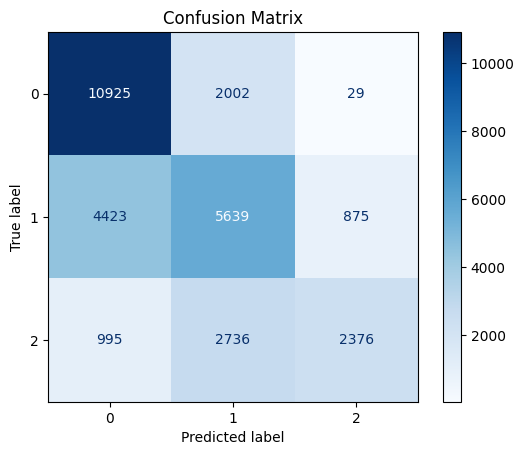

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Fit Random Forest with all CPU cores
rf_1 = RandomForestClassifier(
    n_estimators=1000,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1  # use all cores
)

rf_1.fit(trn_xs, trn_y)

# Evaluate
preds = rf_1.predict(val_xs)
mae = mean_absolute_error(val_y, preds)
print(f"Mean Absolute Error: {mae:.4f}")

# Plot Confusion Matrix
cm = confusion_matrix(val_y, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


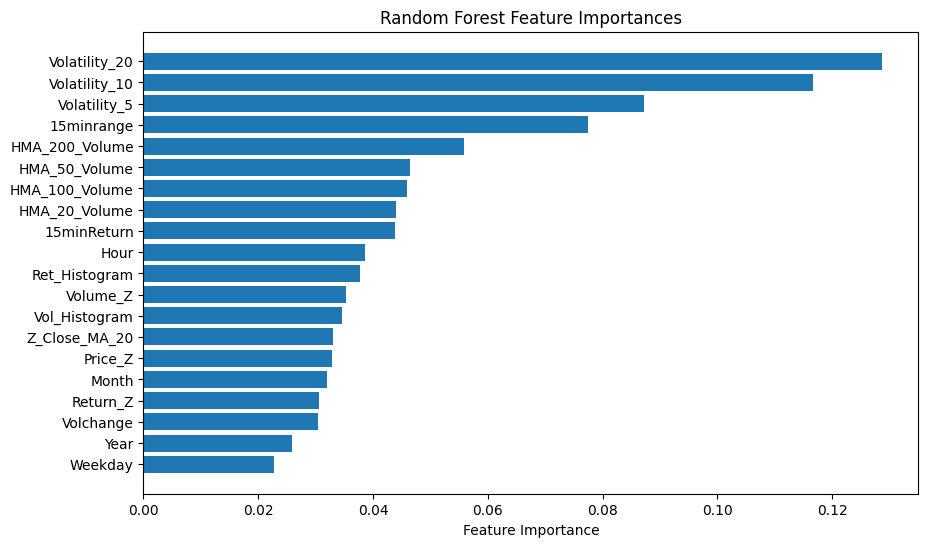

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances
importances = rf_1.feature_importances_
feature_names = trn_xs.columns

# Create a DataFrame and sort
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()
plt.show()


In [32]:
import joblib

joblib.dump(rf_1, 'rf_1_model.pkl')

['rf_1_model.pkl']